# OpenFOAM PMDI validation - droplet size

This program plots the time-average, conditionally spatially-averaged d32 distribution exported from Paraview.
It compares this to Malvern data provided by Roger collected at Woolcock.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 21/11/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import scipy.integrate
%matplotlib notebook

In [2]:
# Get the Malvern data
Malv = {}
dt = ['|S10']
for i in range(40): dt.append('<f8')
    
for f in glob.glob("/Users/dduke/Desktop/PMDI-papers-data/Validation/d32/malvern*.csv"):
    name = os.path.splitext(os.path.basename(f))[0]
    Malv[name] = np.genfromtxt(f,delimiter=',',dtype=dt)

In [3]:
# Convert the mixed array into bin sizes and Cycle PDFs
means={}
favg={}
stds={}
sizes={}

for k in Malv.keys():
    M=Malv[k]
    size_micron = np.array(M[0].tolist()[1:])
    cycles=[]
    for i in range(1,len(M)):
        if b'Cycle' in M[i][0]:
            cycles.append(M[i].tolist()[1:])
        elif b'AVG' in M[i][0]:
            favg[k] = np.array(M[i].tolist()[1:])
    pdf_array = np.vstack(cycles)

    means[k]=np.nanmean(pdf_array,axis=0)
    stds[k]=np.nanstd(pdf_array,axis=0)
    sizes[k]=size_micron    

<IPython.core.display.Javascript object>


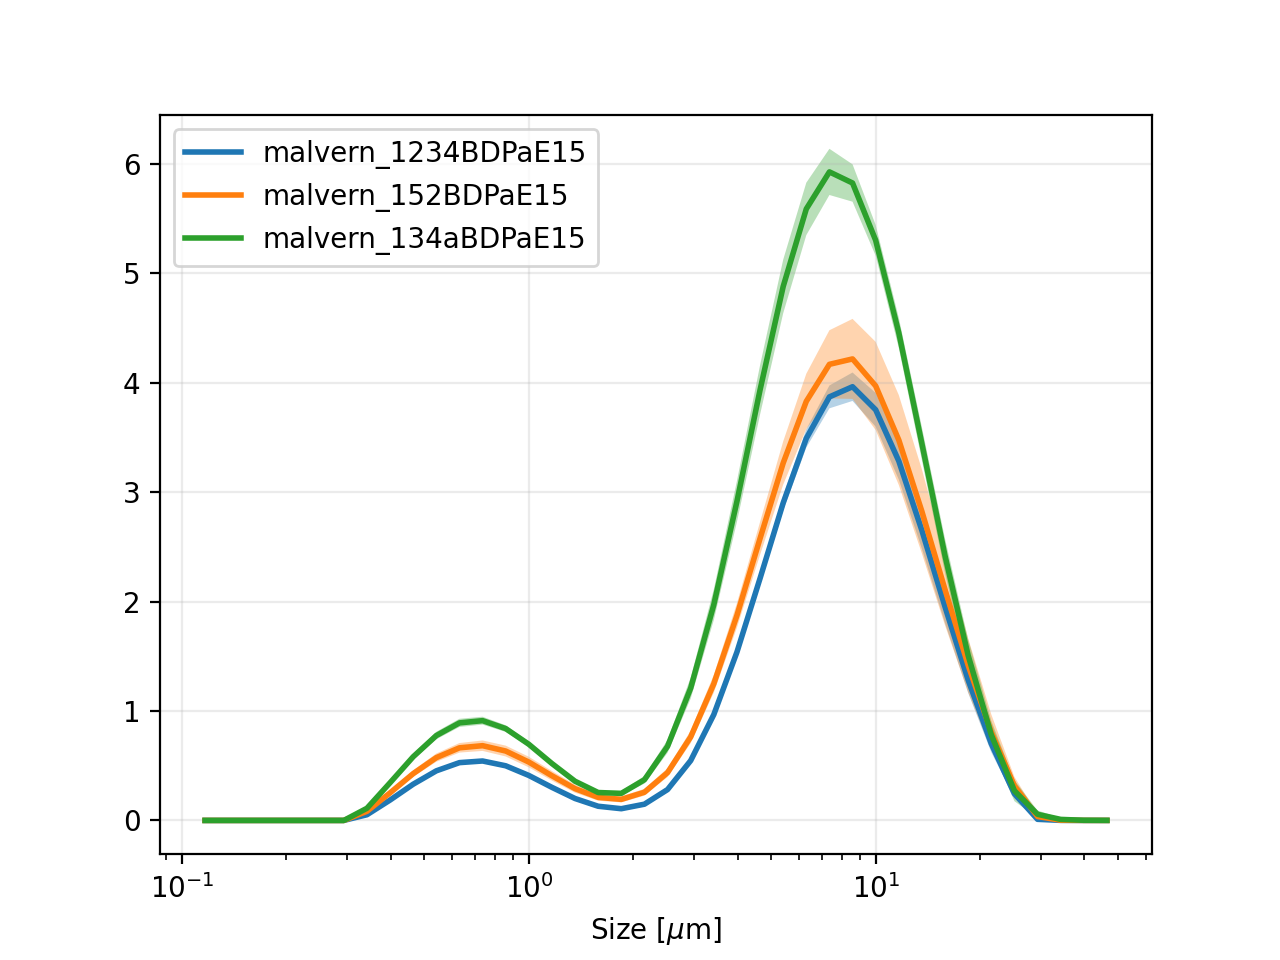

malvern_1234BDPaE15 8.57697582 um
malvern_152BDPaE15 8.57697582 um
malvern_134aBDPaE15 7.35643721 um


In [4]:
# Plot the Malvern data
fig=plt.figure()
ax=fig.add_subplot(111)
plt.grid(alpha=.25)
ax.set_xscale('log')
for k in means.keys():
    ax.plot(sizes[k],means[k],label=k,lw=2)
    ax.fill_between(sizes[k],means[k]-stds[k],means[k]+stds[k],alpha=0.33)
    
    d32 = np.sum(means[k]*sizes[k]**3)/np.sum(means[k]*sizes[k]**2)
    peak = sizes[k][np.where(means[k]==np.max(means[k]))[0][0]]
    print(k,peak,'um')
    #plt.axvline(peak,ls='--')
    
plt.xlabel("Size [$\mu$m]")
plt.legend();

In [34]:
# Get the OpenFOAM data
OF={}
searchPath="/Users/dduke/Desktop/PMDI-papers-data/Validation/d32/ures_d32adj_timeAvg-t0.5.csv"
#searchPath="/Users/dduke/Desktop/PMDI-papers-data/Validation/d32/*d32new.csv"
for f in glob.glob(searchPath):
    name = os.path.splitext(os.path.basename(f))[0].split('_')[0]    
    OF[name]=np.genfromtxt(f,delimiter=',',skip_header=1)

# ures data
columns = ("152a","134a","1234ze","134a15pcEtOH","152a15pcEtOH","1234ze15pcEtOH")

<IPython.core.display.Javascript object>


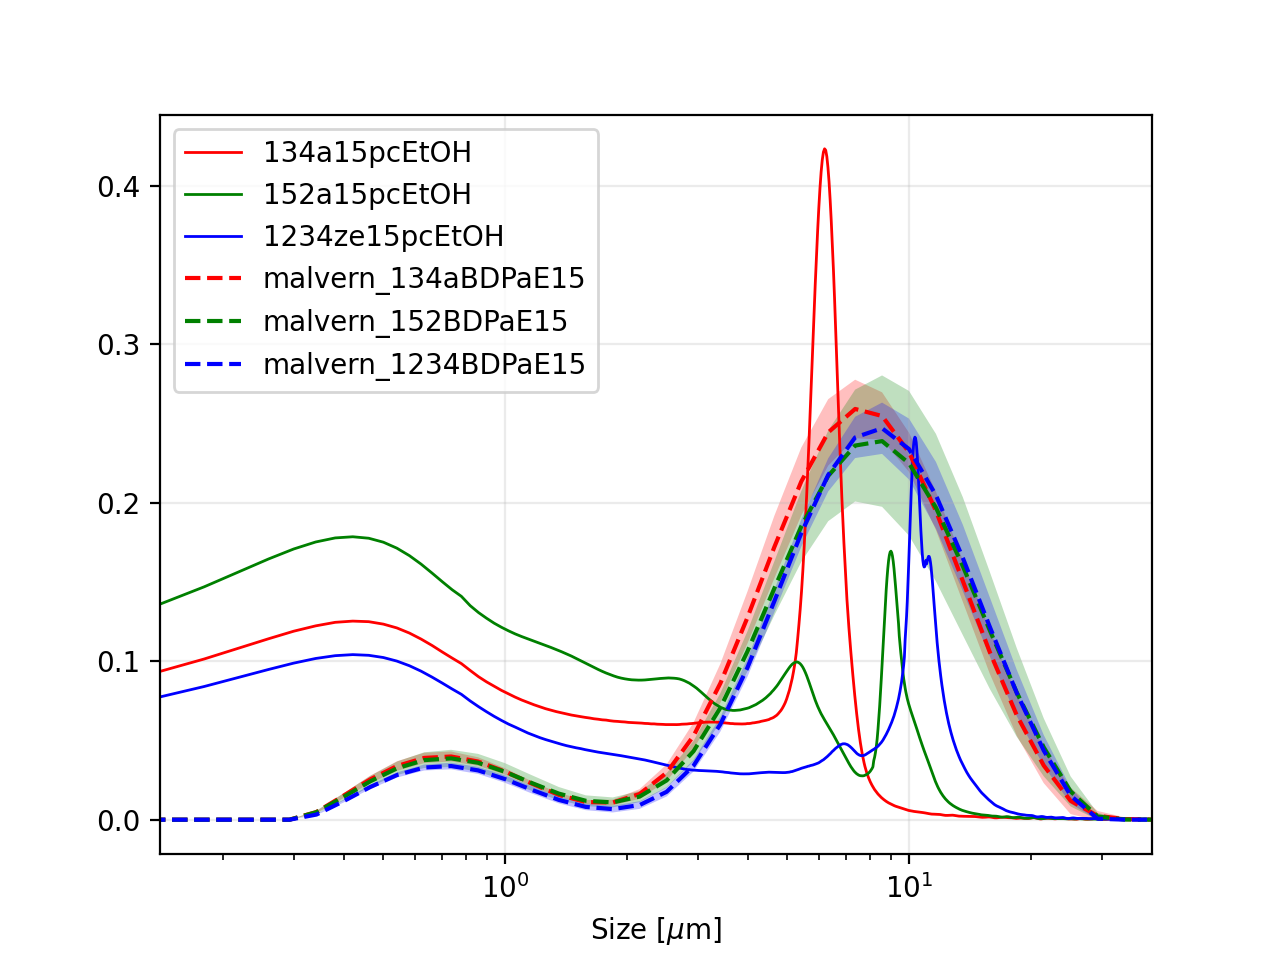

7


In [46]:
# Plot the OpenFOAM data
fig=plt.figure()
ax=fig.add_subplot(111)
plt.grid(alpha=.25)
ax.set_xscale('log')
#ax.set_yscale('log')
kern=np.hamming(32)
kern/=np.sum(kern)

for p in OF.keys():
    l=p
    st = np.where(OF[p][:,0] >= size_micron.min())[0][0]
    sz = OF[p][st:-1,0]
    print(OF[p].shape[1])
    
    #for n in (1,): # newGeomTrial data
            
    for n in range(1,OF[p].shape[1]): # ures data
        l=columns[n-1] # ures data
        
        if '15pcEtOH' in l: # ures data
            
            pdf=OF[p][st:-1,n]
            pdf /= scipy.integrate.simps(pdf,x=sz)
            pdf = np.convolve(pdf, kern, 'same')

            if '134' in l: c='r'
            elif '152' in l: c='g'
            elif '1234' in l: c='b'
            
            ax.plot(sz, pdf, lw=1, label=l, c=c)
            l=None

# Add MALVERN data.
for k in reversed(means.keys()):
    integral=scipy.integrate.simps(means[k],x=sizes[k])
    integral /= 3
    l=k
    if '134' in l: c='r'
    elif '152' in l: c='g'
    elif '1234' in l: c='b'
    ax.plot(sizes[k],means[k]/integral,label=l, ls='--', c=c)
    ax.fill_between(sizes[k],(means[k]-2*stds[k])/integral,(means[k]+2*stds[k])/integral,\
                    alpha=0.25, facecolor=c)        
    i+=1     
plt.xlabel("Size [$\mu$m]")
plt.legend();
plt.xlim(sz.min(),sz.max());
plt.savefig('d32validate.pdf')